### Perform dimensionality reduction on each bird


#### Import packages

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline  
import os
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.transform import resize
import hdbscan 
import umap
from datetime import datetime

In [2]:
from avgn.network_analysis.network_analysis import cluster_data, split_times_into_seqs, syllables_to_sequences, draw_transition_diagram
#import avgn.network.convnet_model as conv
from avgn.network.training import load_from_hdf5

#### Define data parameters

In [3]:
dims = [128, 128, 1] # first dimension of input data
batch_size = 16 # size of batches to use (per GPU)

### Load the dataset

In [4]:
from glob import glob

In [5]:
#Its recommended to use absolute path for the following variables.
hdf_locs = glob('../../../../BirdsongAE/data/syllables_datasets/BF/Bird*')
hdf_locs = glob('../../../data/bf_song_syllables/BF/Bird*_'+str(dims[0])+'.hdf5')
hdf_locs

['../../../data/bf_song_syllables/BF/Bird8_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird7_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird0_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird6_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird9_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird10_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird1_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird2_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird5_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird3_128.hdf5',
 '../../../data/bf_song_syllables/BF/Bird4_128.hdf5']

In [6]:
# What information is stored in the HDF5 file
now_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # this is used to identify this training instance
to_load = ['spectrograms', 'lengths', 'start', 'wav_file', 'syll_start_rel_wav']
nex=32 # for plotting
cluster_pct = 0.025 # we set the minimum cluster size at 0.25% of the dataset ()
# make sequence df

max_timedelta = 10. # seconds # maximum amount of time allowed to pass before considering this bout new
seq_len_cutoff = 2 # syllables/units # minimum amount of syllables/units allowed to be considered part of a sequence


In [7]:
def plot_with_labels(data, labels, title = '', ax = None, figsize = (9,9)):
    palette = sns.color_palette('husl', len(np.unique(labels)))
    labs_to_numbers_dict = {l:i for i,l in enumerate(np.unique(labels))}
    np.random.shuffle(palette)
    colors = [palette[labs_to_numbers_dict[x]] if x >= 0 else (0.75, 0.75, 0.75) for x in np.array(labels)]

    if not ax: fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(data.T[0], data.T[1],
               color=colors, alpha = 1, linewidth= 0, s=5)
    ax.axis('off')
    ax.set_title(title)
    if not ax: plt.show()

Bird7 16743


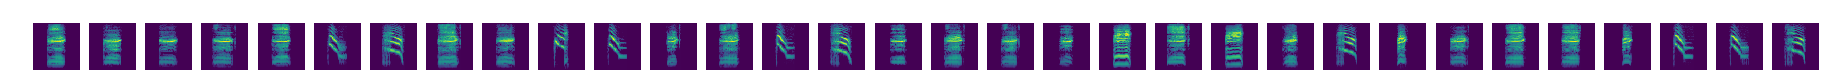

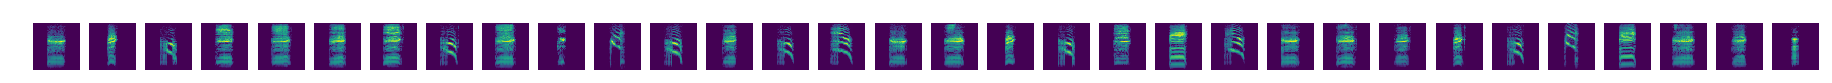

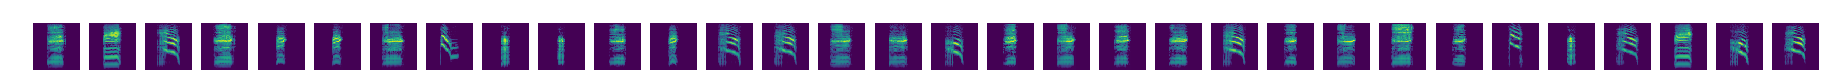

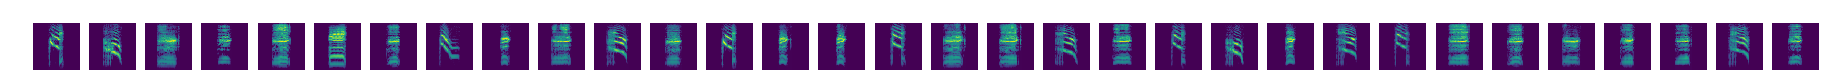

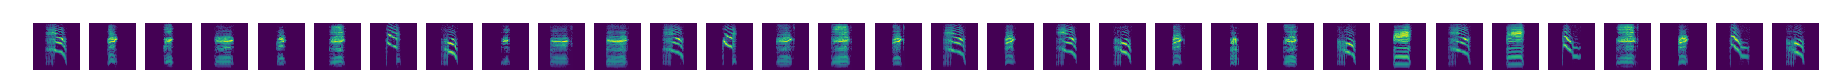

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Clustering took 5.79 s
0.0% of syllables went unlabelled


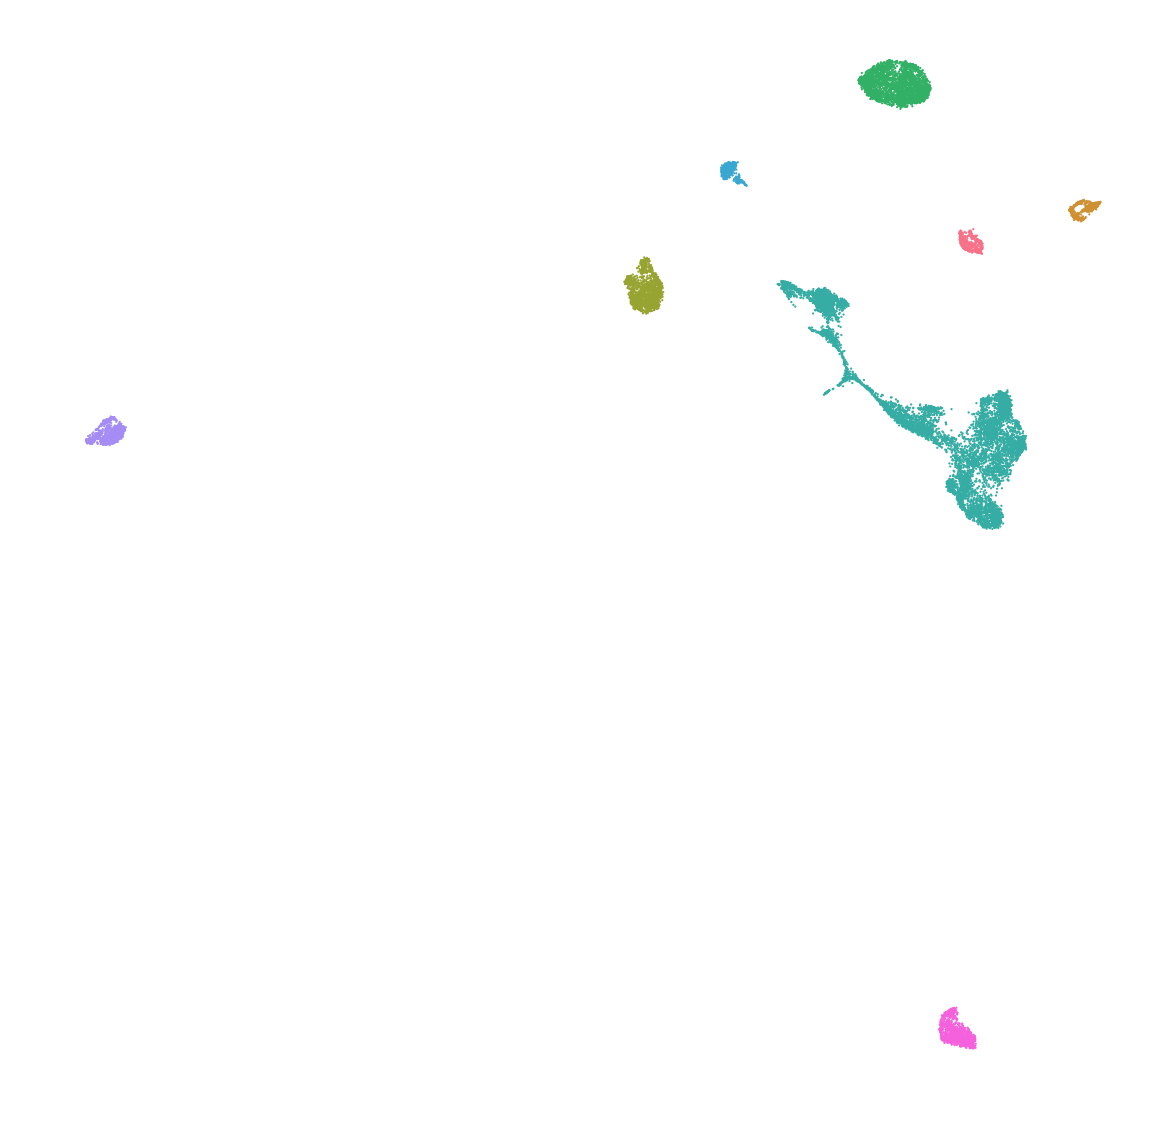

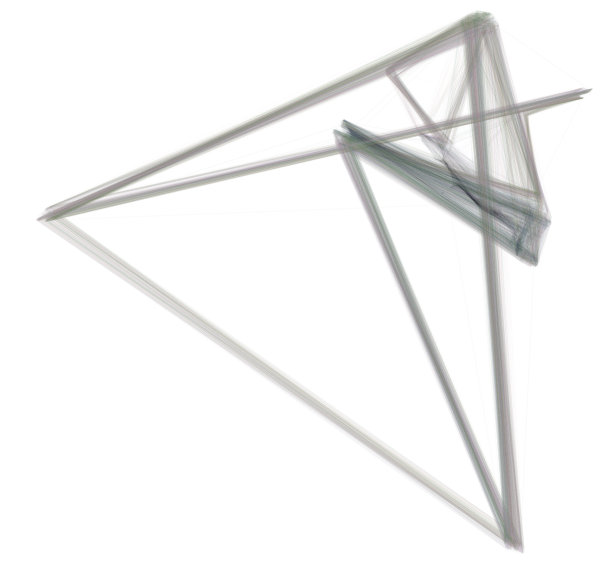

Bird0 6240


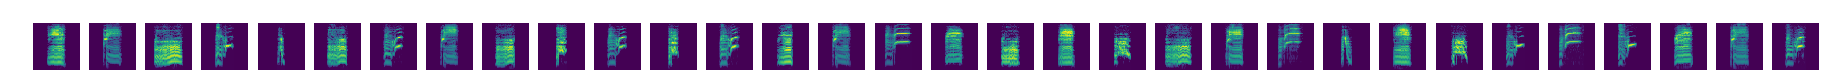

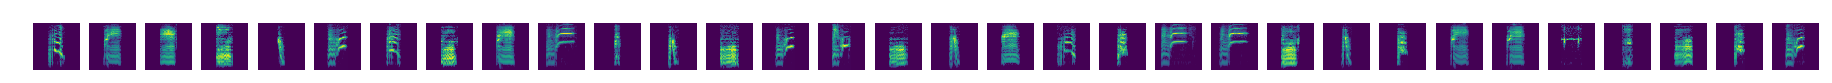

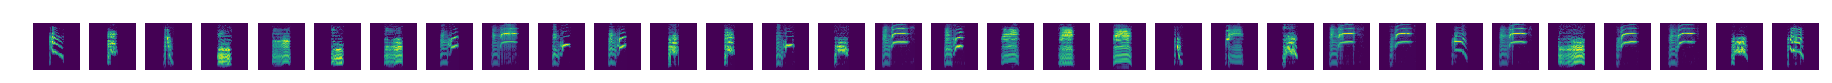

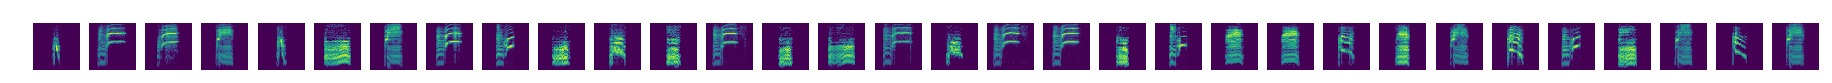

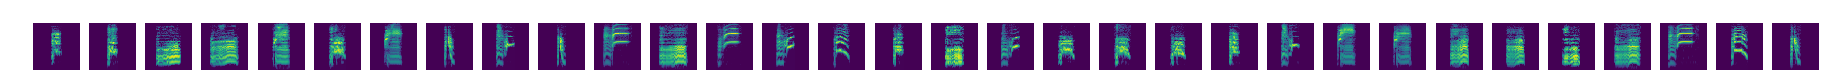

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Clustering took 0.11 s
0.0% of syllables went unlabelled


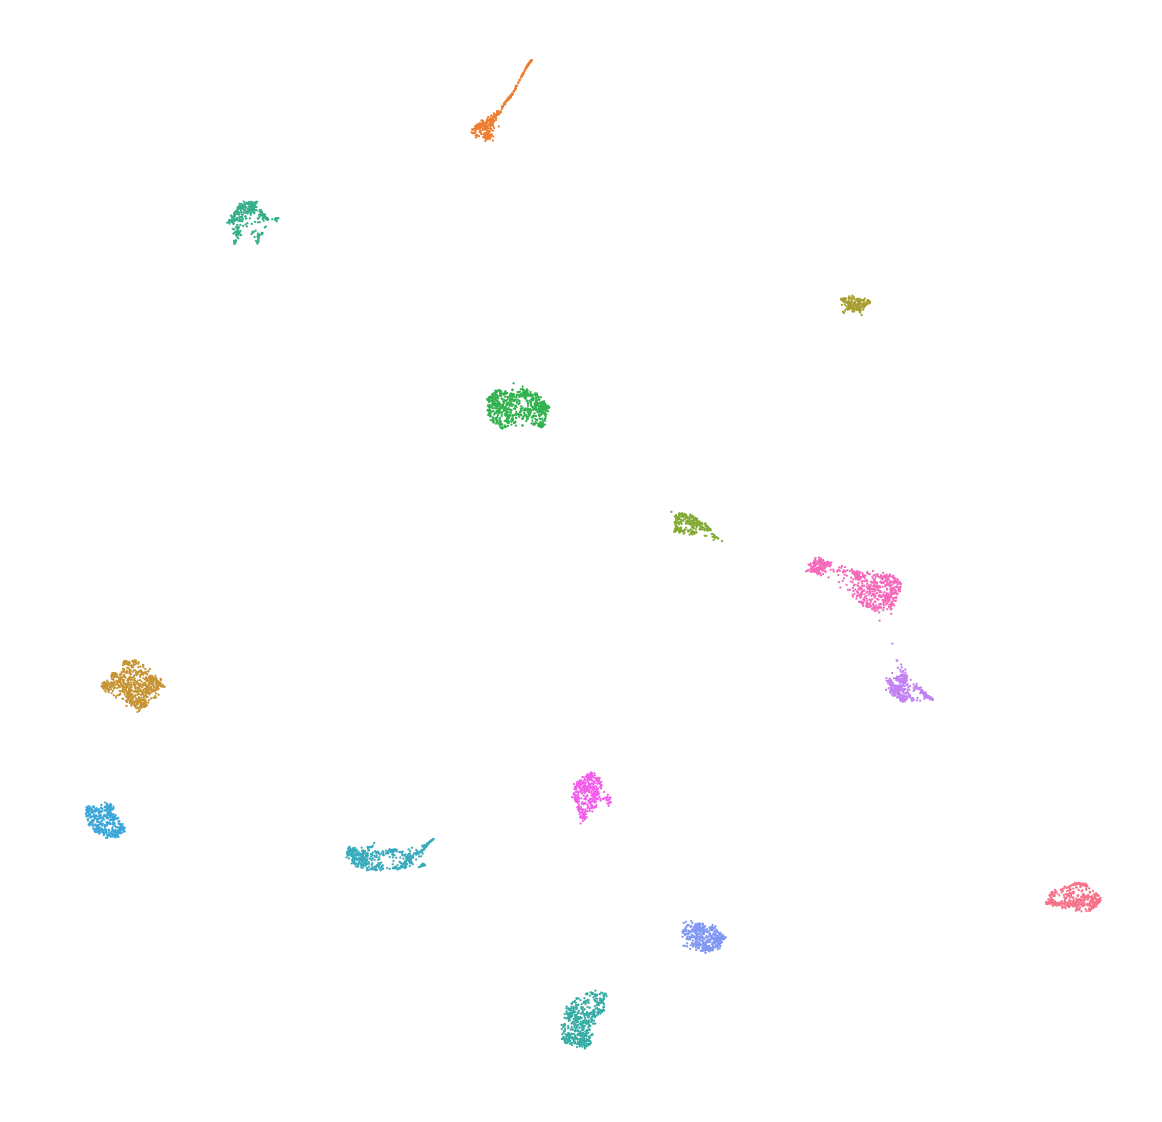

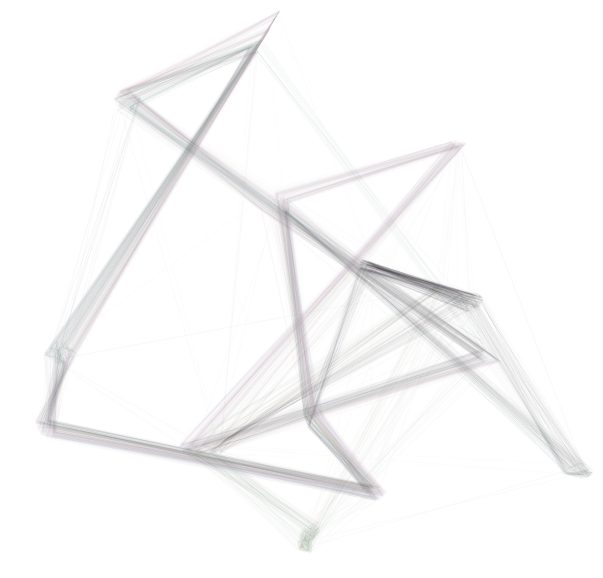

Bird6 12165


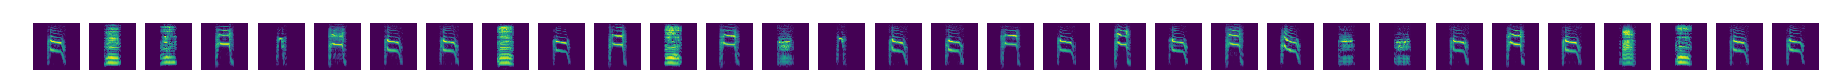

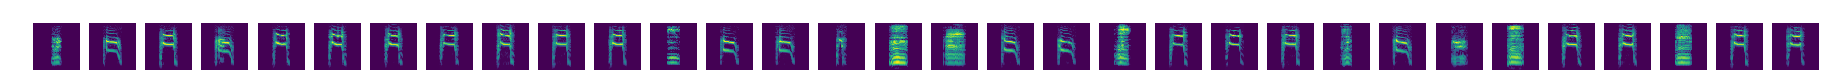

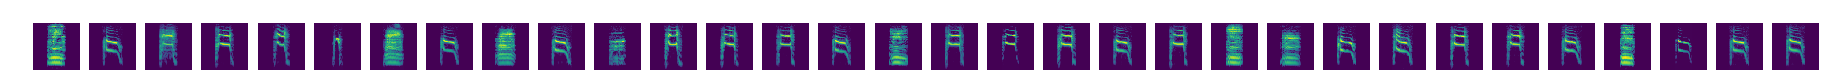

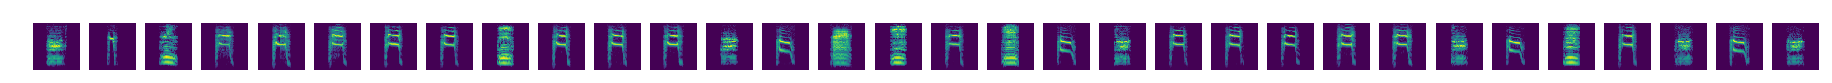

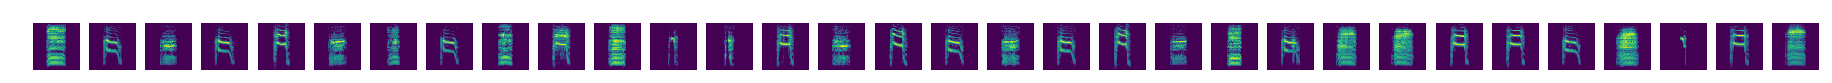

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Clustering took 0.12 s
1.8% of syllables went unlabelled


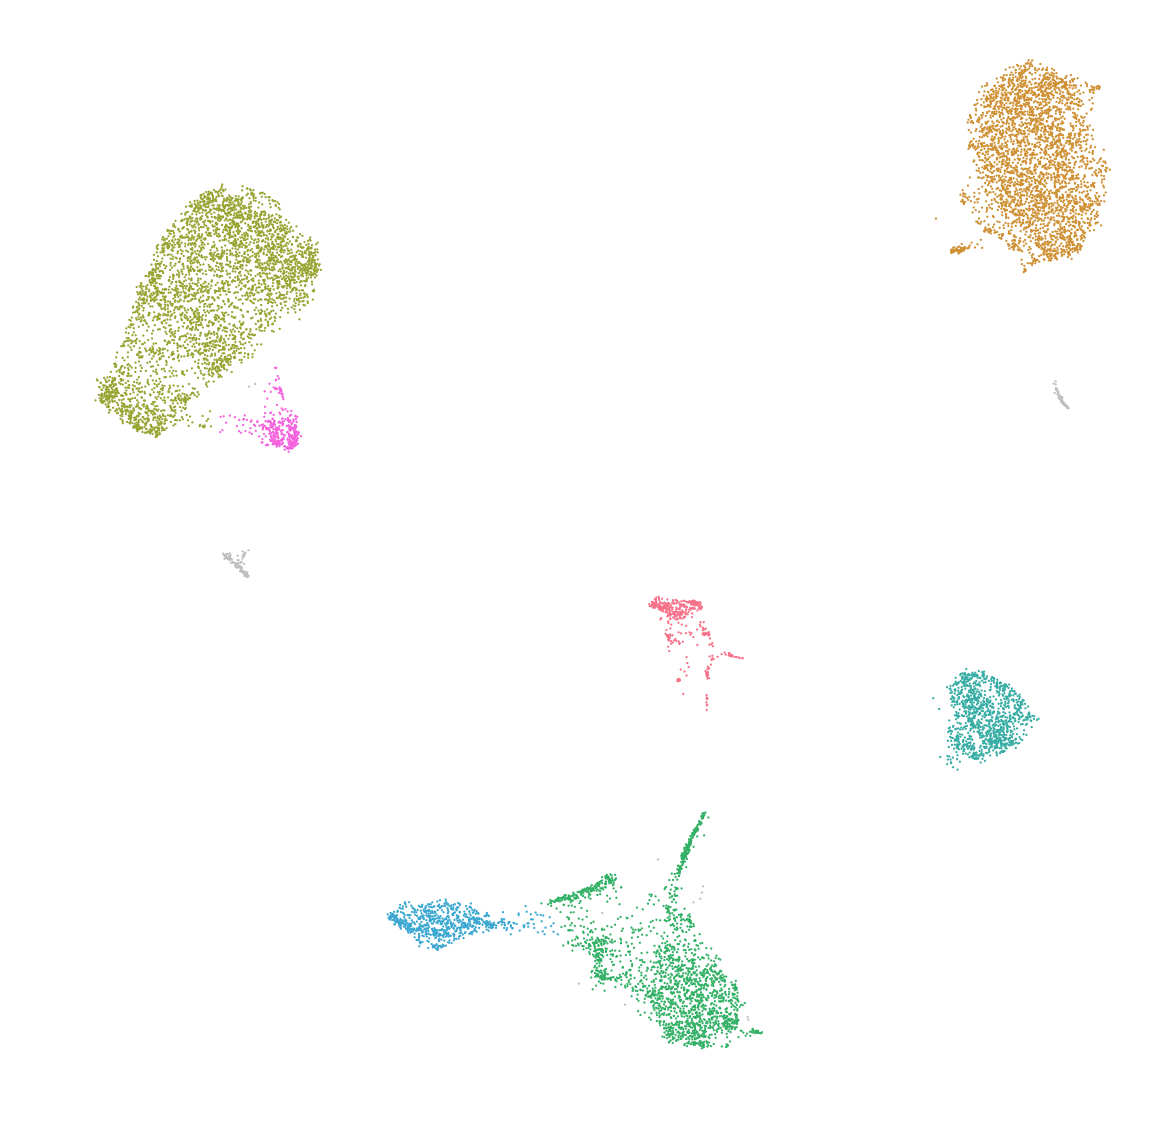

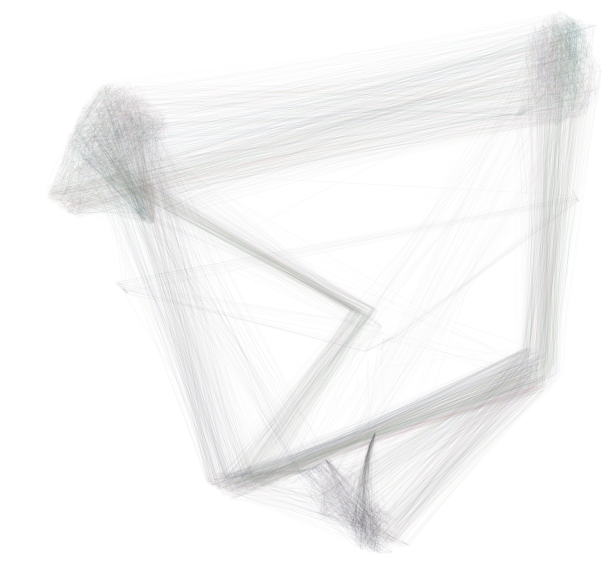

Bird9 15492


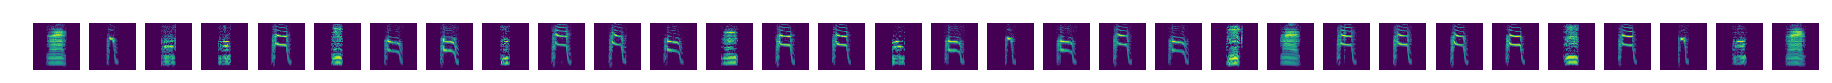

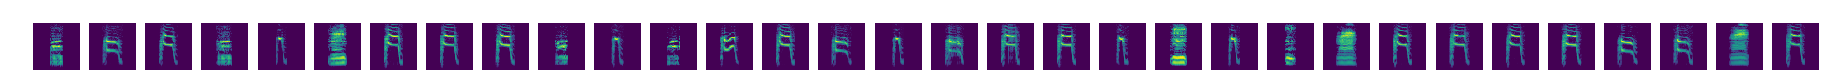

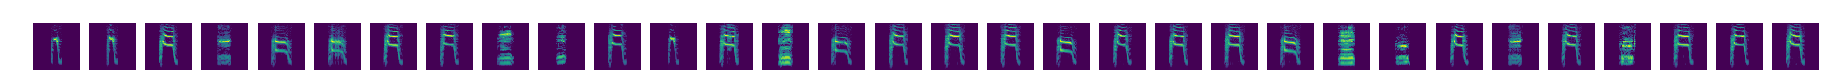

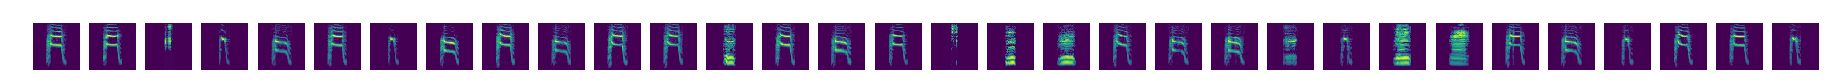

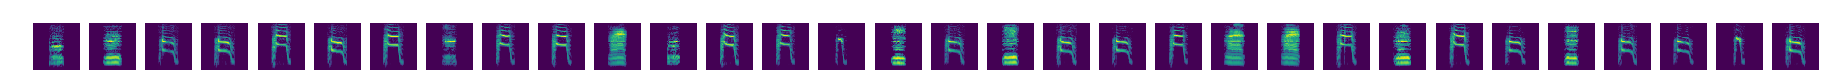

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Clustering took 0.14 s
1.3% of syllables went unlabelled


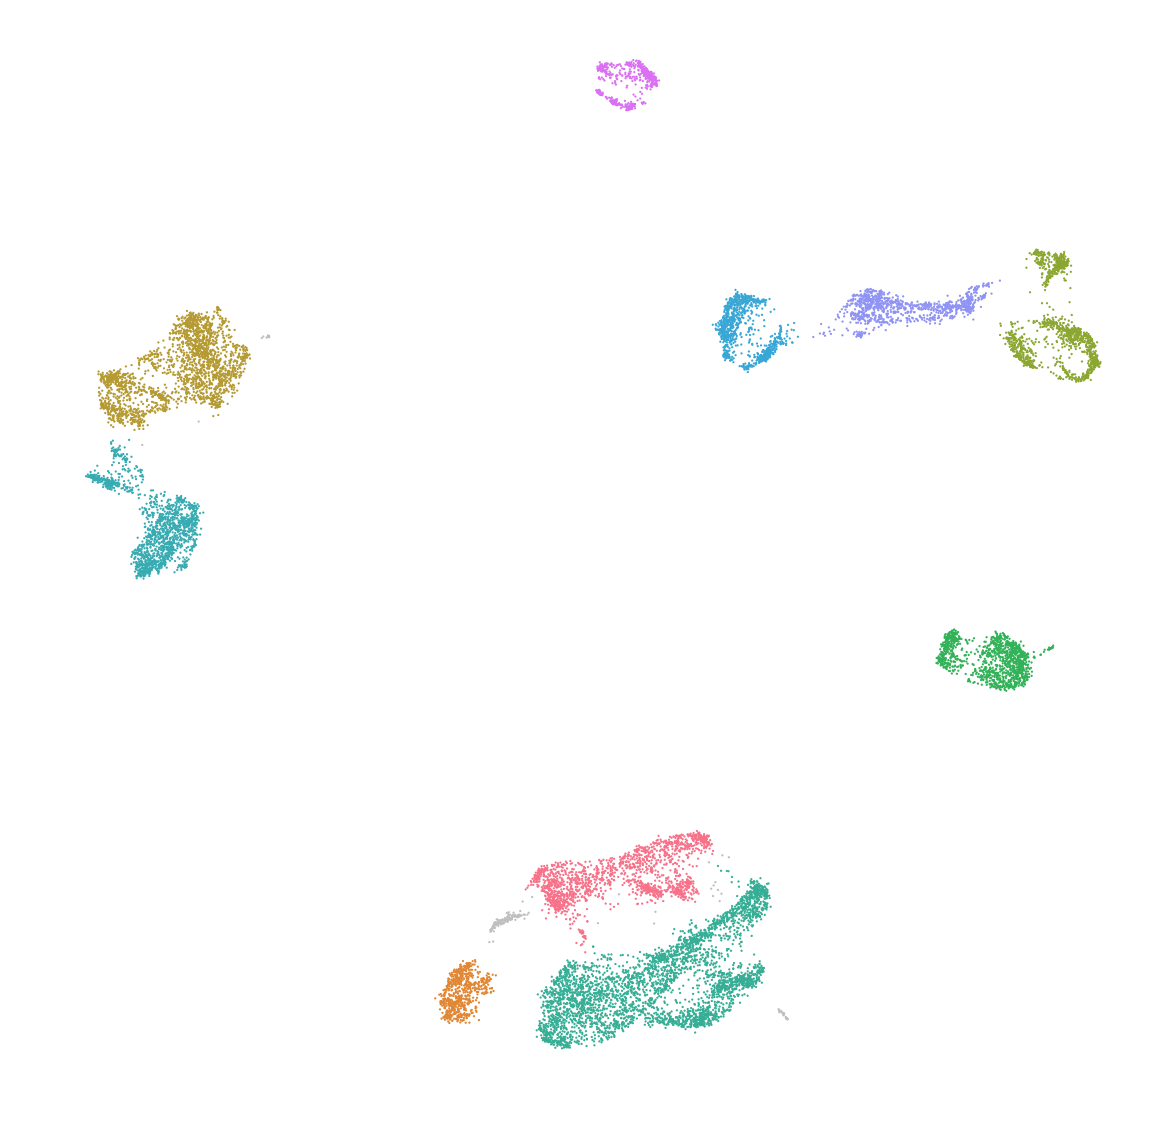

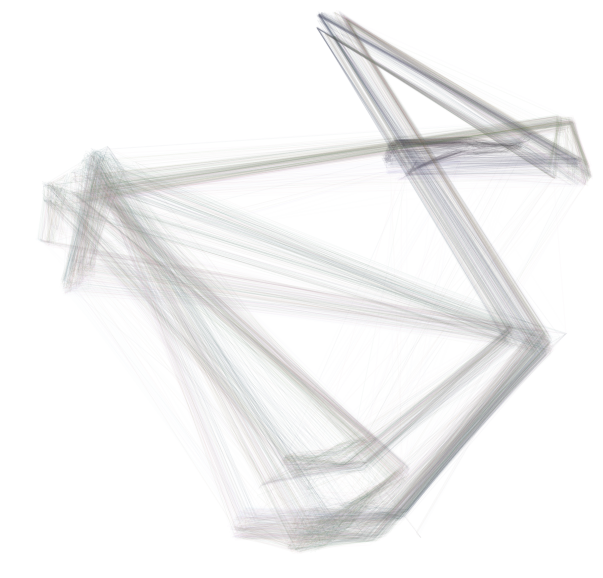

Bird2 23303


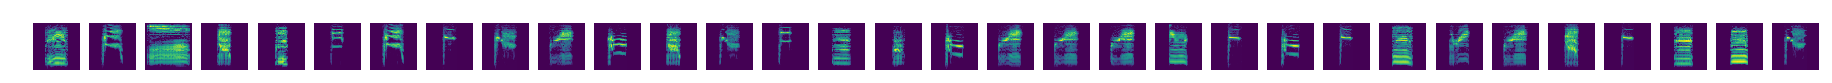

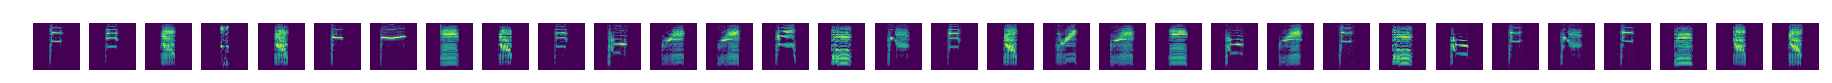

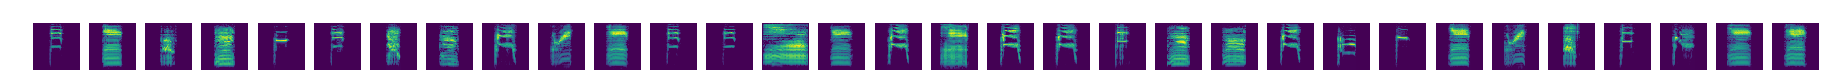

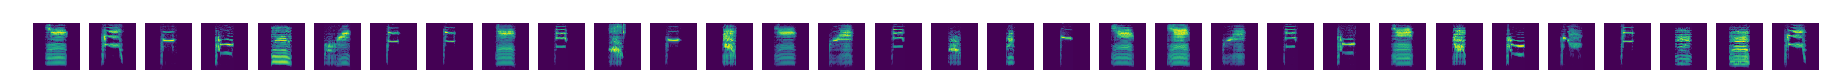

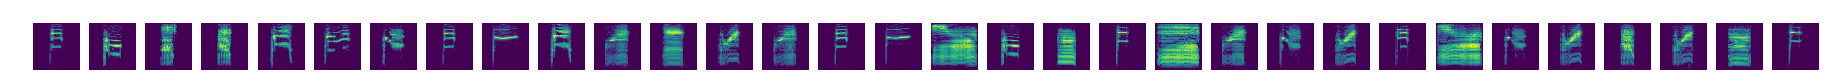

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Clustering took 3.81 s
2.2% of syllables went unlabelled


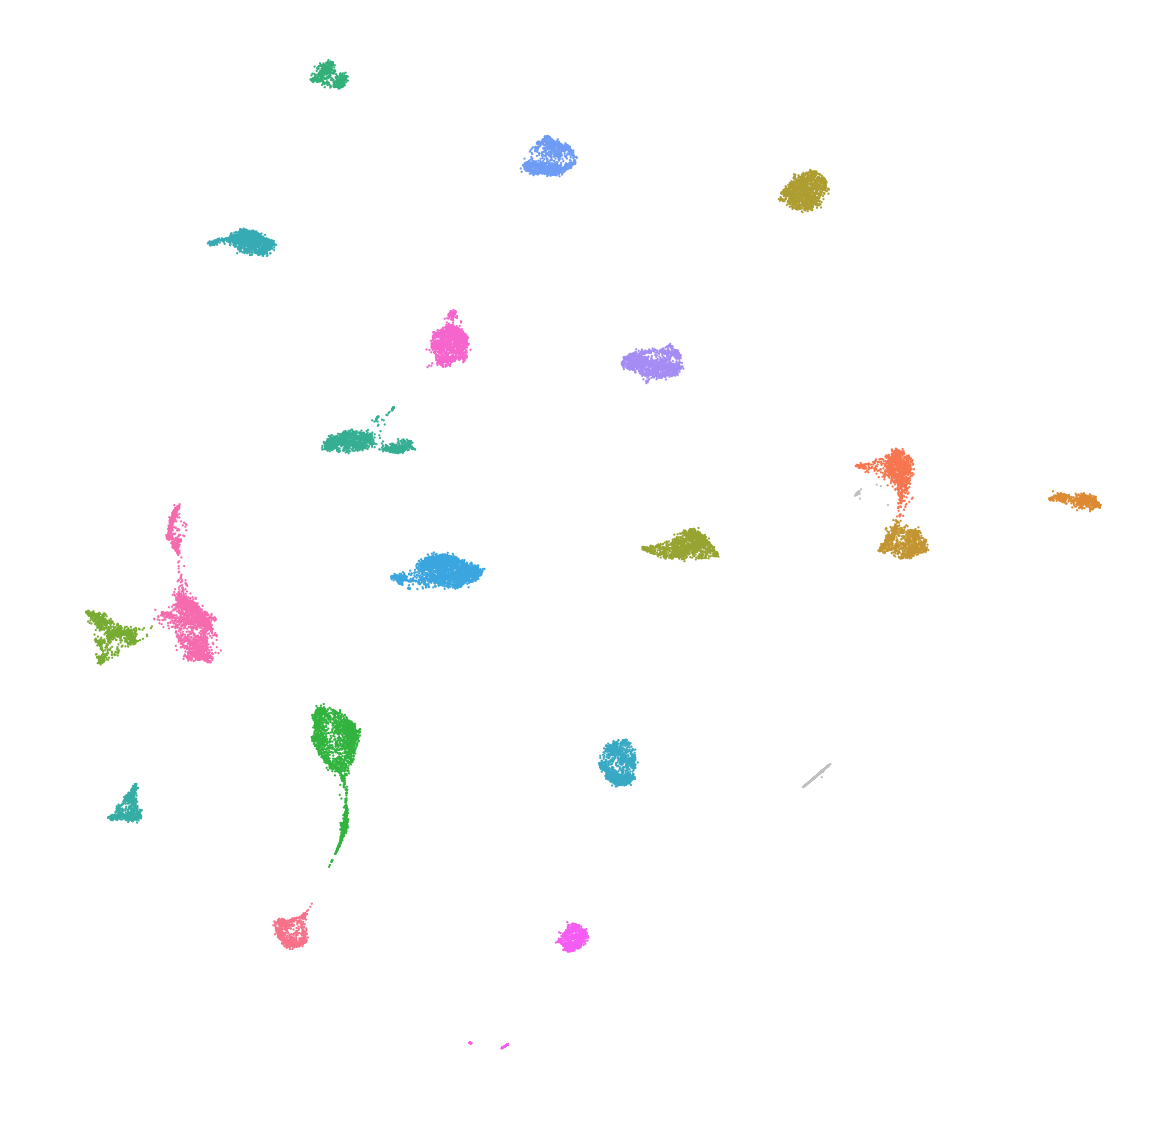

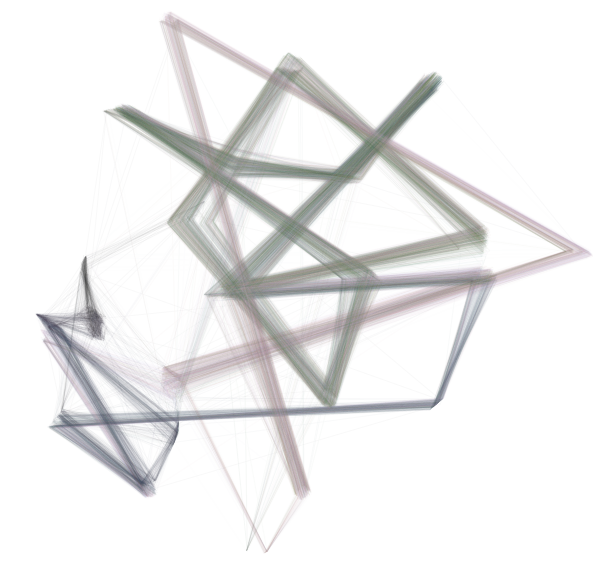

Bird5 15995


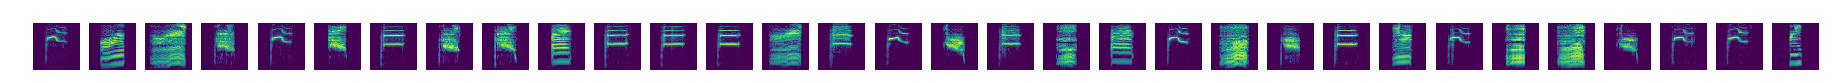

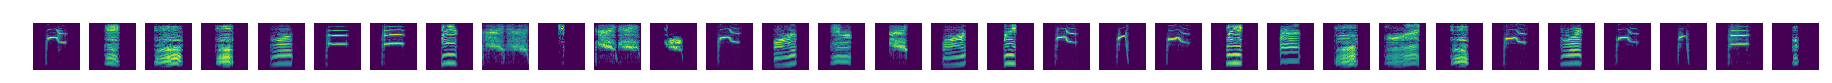

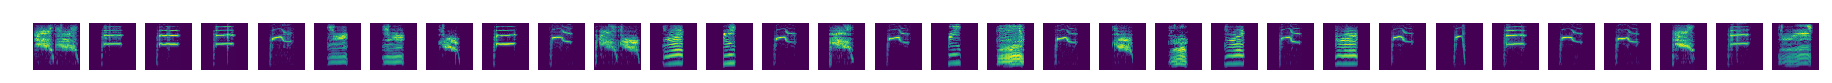

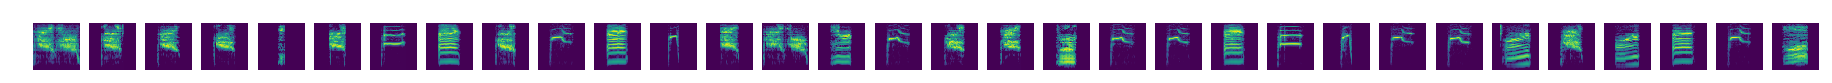

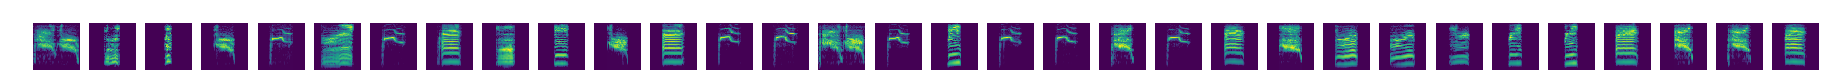

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Clustering took 0.36 s
0.1% of syllables went unlabelled


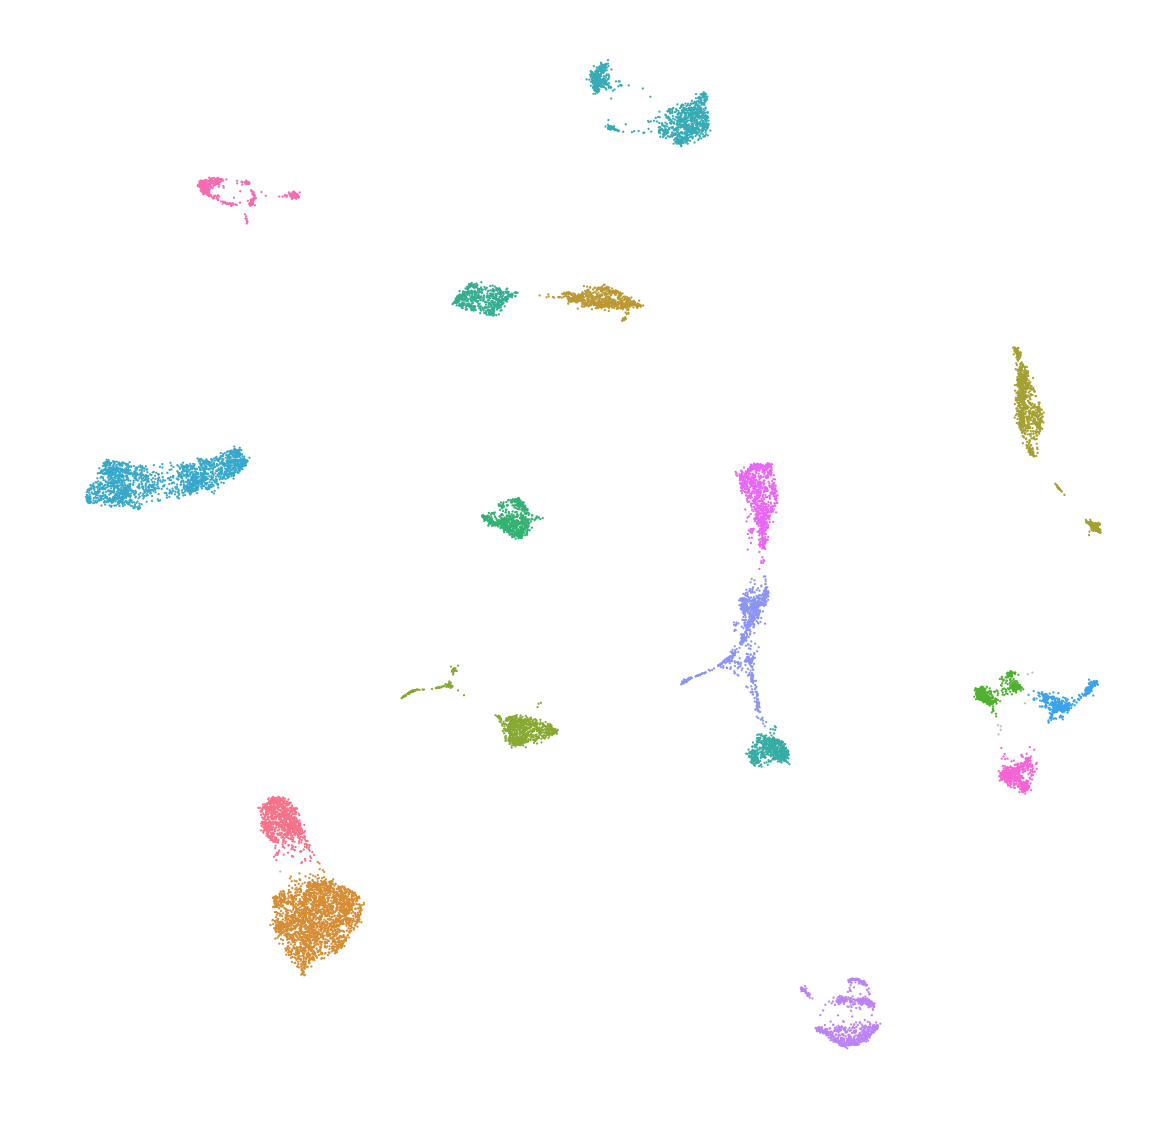

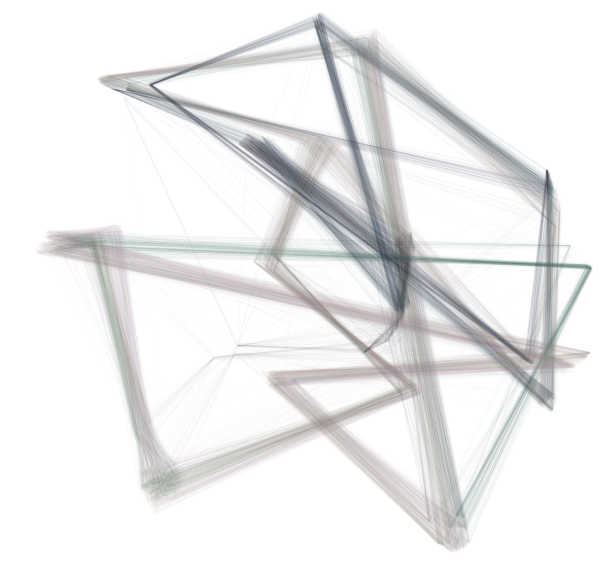

Bird4 16995


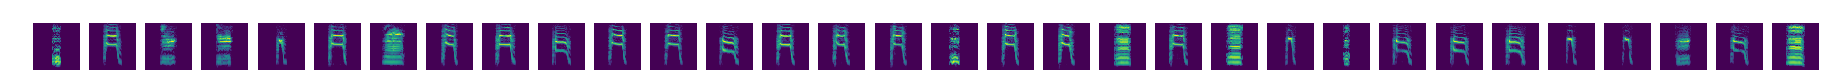

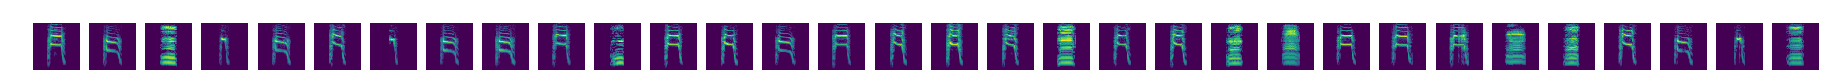

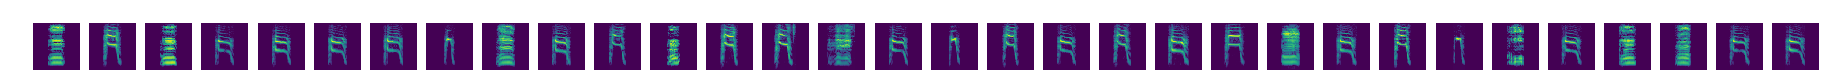

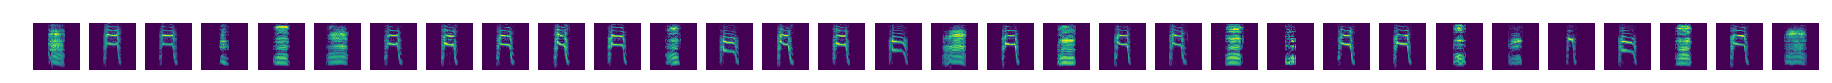

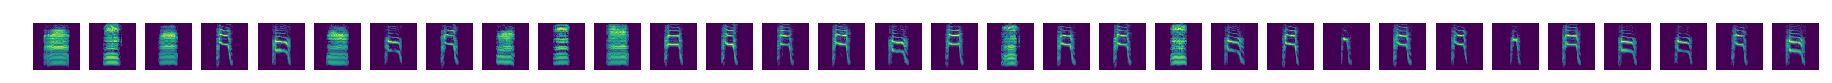

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "



Clustering took 6.96 s
0.0% of syllables went unlabelled


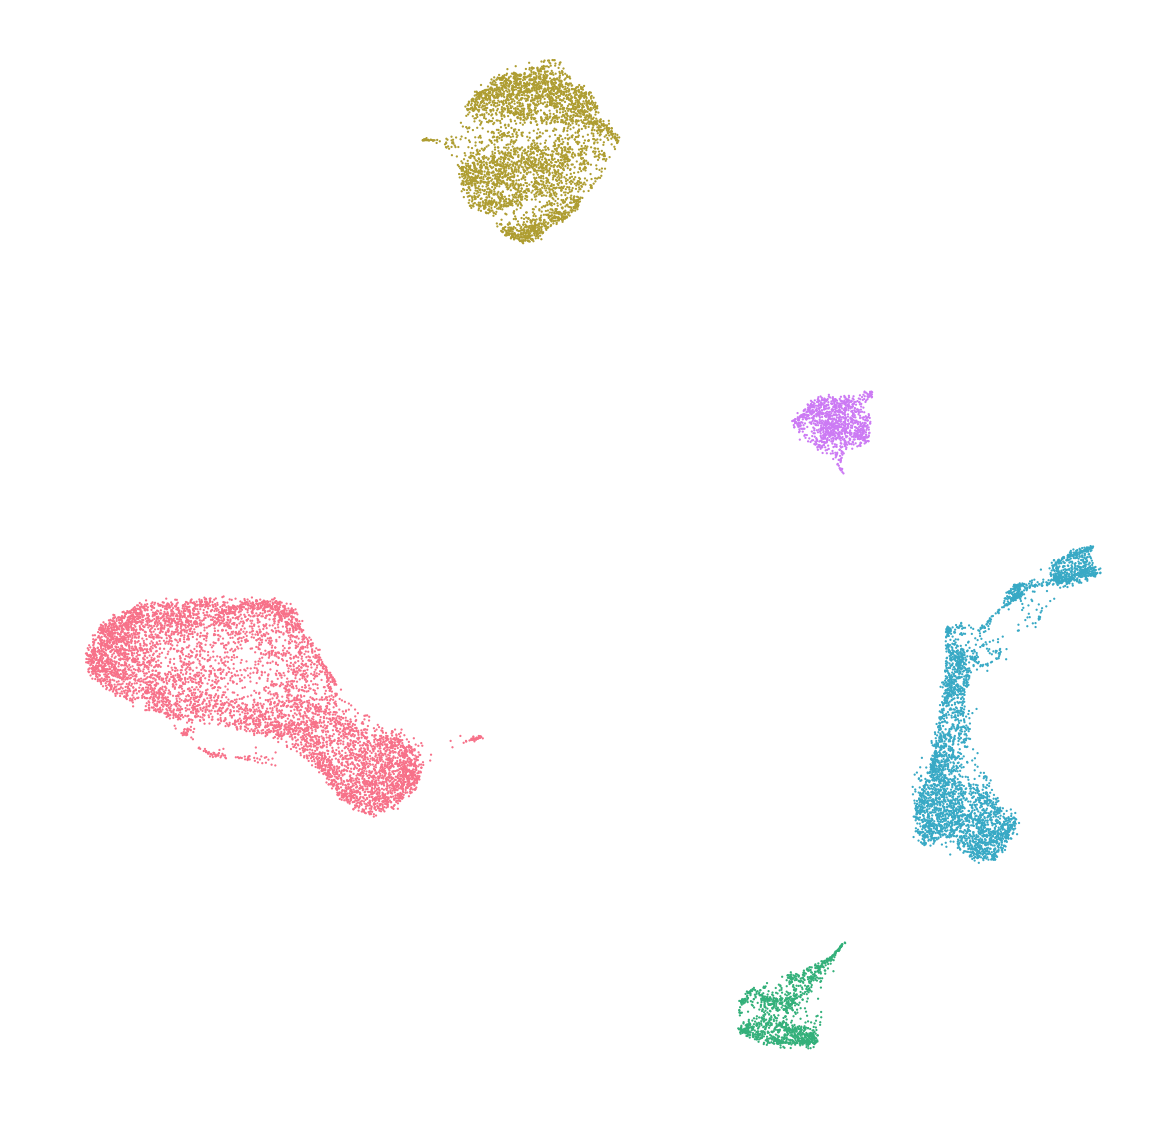

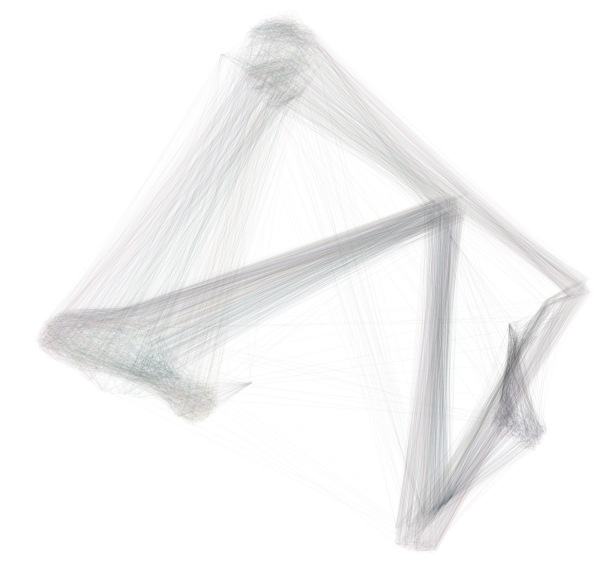

In [10]:
for loc in hdf_locs:
    species = 'starling'
    all_content = load_from_hdf5([loc], to_load)
    num_examples = len(all_content['name'])
    bird = loc.split('/')[-1].split('_')[0]
    if num_examples < 5000: continue 
    # visualize
    print(bird, num_examples)
    for j in range(5):
        fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(nex,1))
        for i in range(nex):ax[i].matshow(all_content['spectrograms'][np.random.randint(num_examples)].reshape((dims[0],dims[1])),
                      cmap=plt.cm.viridis, interpolation='nearest', origin='lower');ax[i].axis('off'); 
        plt.show()
        
    # embed x to z
    x = all_content['spectrograms']
    x_small = [resize(i, [16,16]) for i in tqdm(x)]
    x_small = np.array(x_small).reshape((len(x_small), np.prod(np.shape(x_small)[1:])))
    x_small = [(i*255).astype('uint8') for i in x_small]
    
    clusterable_embedding = umap.UMAP(
        n_neighbors=30,
        #min_dist=0.0,
        n_components=2,
        random_state=42,
    ).fit_transform(x_small)

    # prepare dataframe
    BirdData = pd.DataFrame({
            'specs':all_content['spectrograms'].tolist(), 
            'z':clusterable_embedding.tolist(),
            'syllable_time': [datetime.strptime(i[0], '%d/%m/%y %H:%M:%S.%f') for i in all_content['start'].astype('str').tolist()] , 
            'syll_length_s': all_content['lengths'].tolist(), 
            'start_time_rel_wav': all_content['syll_start_rel_wav'].tolist(), 
            'original_wav': all_content['wav_file'].tolist(), 
        })

    min_cluster_size = int(num_examples*cluster_pct)
    
    # cluster z
    BirdData['labels'] = cluster_data(np.array(list(BirdData.z.values)),
                              hdbscan.HDBSCAN,
                              (),
                              {'min_cluster_size':min_cluster_size,  'min_samples':1},
                             verbose = True)

    # check how many syllables were labelled
    pct_unlabelled = np.sum(BirdData['labels'] == -1)/len(BirdData['labels'])
    print(str(round(pct_unlabelled*100,1))+ '% of syllables went unlabelled')

    # plot clusters
    plot_with_labels(np.array(list(BirdData.z.values)), BirdData['labels'].values, figsize=(20,20))

    # Add sequence information to bird dataframe
    BirdData = split_times_into_seqs(BirdData, max_timedelta, seq_len_cutoff)

    # create a dataset of sequences
    sequence_df = syllables_to_sequences( BirdData, ['labels','z','original_wav', 'specs','start_time_rel_wav','syll_length_s']).rename(columns={'labels': 'sequence'})
    sequence_df['lens'] = [len(i) for i in sequence_df.sequence.values]

    network_identifier = bird+'_umap'

    ### Save the sequence dataframe
    sequence_df_loc = '../../../data/sequence_df/'+'/'+species+'/'+network_identifier+'/'+now_string+'/'
    sequence_df_name = now_string+'.pickle'
    if not os.path.exists(sequence_df_loc):
        os.makedirs(sequence_df_loc) 
    sequence_df.to_pickle(sequence_df_loc+sequence_df_name)

    draw_transition_diagram(sequence_df['z'].values, num_ex=len(sequence_df), alpha=.025, linewidth=1, cmap=plt.get_cmap('cubehelix'))
    plt.show()